<h1><u><center> Economic Scenario Generator Project - Projet DDEFI </center></u></h1>
<img src = "https://www.econostrum.info/photo/art/grande/36648656-32651177.jpg?v=1566465679" 
     title = "NASDAQ Logo" alt = "Nasdaq Logo" width="300">

<h3><center> Anaïs Auzanneau / Alison Cortesi / Germain Lefebvre / Florent Morin / Vincent Bilger</center></h3>

<h4><center> - </h4></center>
<h4><center> École Centrale Marseille </h4></center>

### Sommaire  <a class="anchor" id="sommaire"></a>

* [0 - Importation des ressources](#chapter0)
* [I - Conversion des données en rendements logarithmiques](#chapter1)
    * [Complétement : Modélisation d'une portefeuille d'actions pondéré](#chapter1.complement)
    
* [II - Préparation de notre data set pour la simulation ](#chapter2)

* [III - Premières modélisations - Plusieurs méthodes paramétriques](#chapter3)
    * [III.1  Préparation de 3 modèles paramétriques](#chapter3.section1) 
        * [III.1.1 - Modèle AR(1)](#chapter3.section1.1)
        * [II.1.2 - Modèle GARCH(1,1)](#chapter3.section1.2)
        * [III.1.3 - Modèle EGARCH(1,1)](#chapter3.section1.3)
    * [III.2 - Simulations grâce à nos modèles](#chapter3.section2)
        * [II.2.1 - Simulation avec AR(1)](#chapter3.section2.1)
        * [III.2.2 - Simulation avec EGARCH(1,1)](#chapter3.section2.2)
        * [III.2.3 - Simulation avec GARCH(1,1)](#chapter3.section2.3)
        * [III.2.4 - Simulation avec FHS (AR et GARCH)](#chapter3.section2.4)
        
* [IV- Bootstrapping & 1ère analyse](#chapter4)
    * [IV.1 - Bootstrapping](#chapter4.section1)
    * [IV.2 - Première analyse](#chapter4.section2)
    * [IV.3 - Comparaison avec les valeurs réelles](#chapter4.section3)
    
* [V - Fonction Prediction_Boostrapping](#chapter5)

* [VI - Fonction de performance](#chapter6) 
    * [VI.1 - Fonctions de mesures](#chapter6.section1)
    * [VI.2 - Fonction Describe](#chapter6.section2)
    * [VI.3 - Comparaison des prévisions par boostrapping et des modèles AR(1), GARCH(1,1) et AR(1)-GARCH(1,1)](#chapter6.section3)

* [VII - Filtred Historical Simulation ](#chapter7)

## 0 - Importation des ressources <a class="anchor" id="chapter0"></a>

In [1]:
# conda install -c saravji pmdarima
# conda install -c conda-forge statsmodels

import pandas as pd                                       #Used in all section
import numpy as np                                        #Used in all section
from math import *                                        #Used in all section
import datetime                                           #Used in section 0
from datetime import date                                 #Used in section 0
from statsmodels.tsa.arima_model import ARIMA             #Used in section 3.1.1
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import pmdarima as pm                                     #Used in section 3.1.1              
#from pmdarima.arima import ARIMA                          #Used in section 3.1.1
from statsmodels.graphics.tsaplots import plot_acf        #Used in section 3.1.2 et 3.1.3
from arch import arch_model                               #Used in section 3.1.2 et 3.1.3
import random                                             #Used in section 4 and 5
import matplotlib.pyplot as plt                           #Used in all section
import plotly.graph_objects as go                         #Used in section 4.3
plt.style.use('ggplot')
from scipy import stats                                   #Used in section 6.1
from scipy.stats import f_oneway                          #Used in section 6.1 
from scipy.stats import mannwhitneyu                      #Used in section 6.1
from scipy.stats import wasserstein_distance              #Used in section 6.1
from scipy.stats import wilcoxon                          #Used in section 6.1 

$! Attention !$ Ne pas oublier de changer le chemin ci-dessous en fonction de l'utilisateur afin d'arriver au fichier contenant les bases de données.

In [2]:
# root_path = 'C:/Users/anais/Documents/Centrale/Cours/3A/DDEFi/Projet DDEFi/Ressources/Data/'      #Anais
root_path = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/'                         #Germain
# root_path = 'C:/Users/flomo/Desktop/Projet BNP/Data/'                                             #Florent
# root_path = 'C:/Users/Vincent/Desktop/PROJET DDEFI/DATA/'                                         #Vincent
# root_path = 'C:/Users/alisoncortesi/Desktop/ECM_3A/OPT_DDEFI/TC_PROJDDEFI                         #Alison
# root_path = 'D:/Utilisateurs/JLEQ/BP2S/Datas/'                                                    #Julien                                                          #Julien

Importation de nos 3 bases d'indices afin de pouvoir selectionner les données souhaitées.

In [3]:
Actions = pd.read_csv(root_path+'BDD_Index.csv')
Taux = pd.read_csv(root_path+'BDD_Rates.csv')
Echanges = pd.read_csv(root_path+'BDD_Exchange.csv')

Actions['Date'] = pd.to_datetime(Actions['Date'])
Actions = Actions.set_index(keys = 'Date', drop = True)

Taux['Date'] = pd.to_datetime(Taux['Date'])
Taux = Taux.set_index(keys = 'Date', drop = True)

Echanges['Date'] = pd.to_datetime(Echanges['Date'])
Echanges = Echanges.set_index(keys = 'Date', drop = True)

Afin de mieux visualiser les données à notre disposition, nous commençons par tracer l'évolution temporelle de nos données brutes.

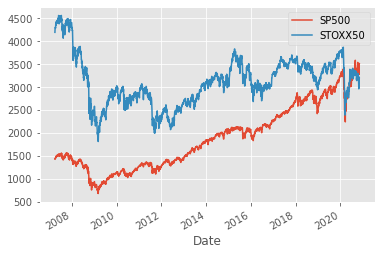

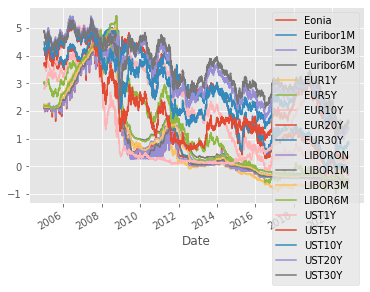

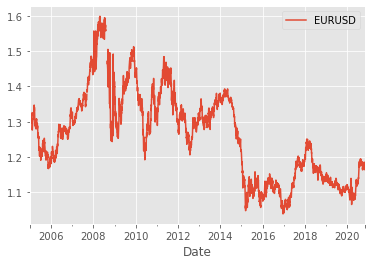

In [4]:
Actions.plot()
Taux.plot()
Echanges.plot()

Afin de pouvoir étudier un panel important de données, et notamment des taux, nous importons ici un grand nombre de fichier.
Dans un premier temps, toutes les données importées ne seront pas utilisées.
Dans les 6 prochains chapitres, nous ne nous interesserons qu'aux deux indices STOXX50 et S&P500.

Ci-dessous, un schéma récapitulatif des données aggrégées : 

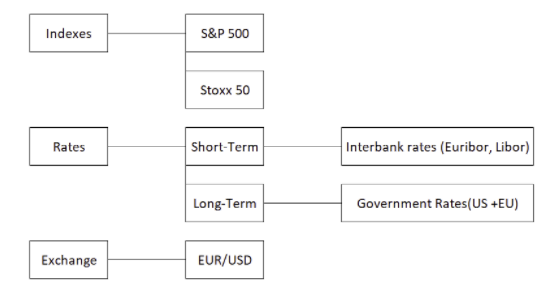

In [5]:
class Series:
    
    def __init__(self, name, values, type_serie):
        self.name = name # nom de la série
        self.values = values # dataframe des valeurs
        self.type_serie = type_serie
    
    # Fonction qui plot les données
    def visualization(self):
        plt.plot(self.values)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Evolution of ' + self.name)
    
    # Fonction qui plot et retourne le tableau des valeurs des rendements
    def returns(self):
        if self.type_serie == "Action":
            var_pct = self.values.pct_change().dropna()
            ret = np.log(1 + var_pct)
        if self.type_serie == "Taux":
            ret = self.values.diff().dropna()
        plt.plot(ret)
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title('Daily Logarithmic Returns for ' + self.name)
        return(ret)
    
    # Fonction qui renvoie la partie "training" du dataset
    def training(self):
        ret = self.returns()
        plt.close()
        T=int(np.floor(len(ret.index)*0.8))
        return(ret[0:T-1])
    
    # Fonction qui renvoie la partie "testing" du dataset
    def testing(self):
        ret = self.returns()
        plt.close()
        T=int(np.floor(len(ret.index)*0.8))
        return(ret[T:])
    
    # Fonction qui fit et renvoie un modèle Arima optimal pour les rendements de la série
    def arima(self, pmax, qmax):
        training_data = self.training()
        best_pq=[0,0]
        AIC = 0
        for p in range(1,pmax+1):
            for q in range(0,qmax+1):
                model = ARIMA(training_data,(p, 1, q))
                fit = model.fit(disp=-1)
                if fit.aic<AIC:
                    AIC = fit.aic
                    best_pq[0]=p
                    best_pq[1]=q
        model = ARIMA(training_data,(best_pq[0], 0, best_pq[1]))
        fit = model.fit(disp=-1)
        return(best_pq,fit)
    
    # Fonction qui fit et renvoie un modèle Garch optimal pour les rendements de la série
    def garch(self, pmax, qmax):
        training_data = self.training()
        best_pq=[0,0]
        AIC = 0
        for p in range(1,pmax+1):
            for q in range(qmax+1):
                model = arch_model(training_data,p=p,q=q,rescale=False)
                fit = model.fit(update_freq=5,disp='off')
                if fit.aic<AIC:
                    AIC = fit.aic
                    best_pq[0]=p
                    best_pq[1]=q
        model = arch_model(training_data.iloc[:,0], vol='garch', p=best_pq[0], o=0, q=best_pq[1], rescale=True)
        fit = model.fit(update_freq=5,disp='off')
        return(best_pq,fit)
    
    # Fonction de prédiction paramétrique des returns (à revoir)
    def arima_modelisation(self, pmax, qmax):
        training_data=self.training()
        testing_data=self.testing()
        best_pq , fit = self.arima(1,1)
        predicted_returns = fit.forecast(steps=len(testing_data))[0]
        predicted_returns=pd.DataFrame({'Forecasts' : predicted_returns}, index=testing_data.index)
        plt.plot(testing_data, c='k',label='Real data')
        plt.plot(predicted_returns, c='r',label='Predicted data')
        plt.title('Rendements prédits par processus ARMA')
        plt.legend()
    
    # Fonction de prédiction paramétrique des returns (à revoir)
    def garch_modelisation(self, pmax, qmax):
        training_data=self.training()
        testing_data=self.testing()
        best_pq , fit = self.garch(3,3)
        forecasts = fit.forecast(horizon=len(testing_data))
        volatility = forecasts.variance.dropna().T**(1/2)
        mean = forecasts.mean.dropna().T
        pred = mean + volatility
        pred.index=testing_data.index
        plt.plot(testing_data, c='k',label='Real data')
        plt.plot(pred, c='r',label='Predicted data')
        plt.title('Rendements prédits par processus GARCH')
        plt.legend()
        
    # Fonction qui utilise la méthode HS (simple bootstrap) pour prédire les rendements/prix
    def historical_simulation(self,nb_paths):
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[len(training_data)-1])
        bootstrapped_returns = pd.DataFrame([random.choices(list(training_data.iloc[:,0]), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
    
    
    # Fonction qui utilise la méthode FHS (bootstrapping sur rendements standardisés) pour prédire les rendements/prix    
    def filtered_historical_simulation(self,nb_paths):  
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[len(training_data)-1])
        best_pq,model = self.garch(5,5)
        volatility = model.conditional_volatility
        standardized_returns = training_data.iloc[:,0]/volatility
        
        bootstrapped_returns = pd.DataFrame([random.choices(list(standardized_returns), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements standardisés bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
       
    # Fonction qui compare les résultats de nos différentes méthodes
    def describe(self):
        simulated_data_HS=self.historical_simulation(1000)
        plt.close()
        simulated_data_FHS=self.filtered_historical_simulation(1000)
        plt.close()
        testing_data = self.testing()
        plt.close()
        plt.clf()
        Data = pd.DataFrame({'Testing Set' : list(self.testing().iloc[:,0]), 'Simulated Data HS' : list(simulated_data_HS),'Simulated Data FHS' : list(simulated_data_FHS)}, index=testing_data.index)
        
        res = Data.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res.loc['Median Absolute Deviation'] = Median_Abs_dev(Data) #Add MAD measurement to the recap table
        res.loc['skew'] = skewness(Data)                                   #Add skew measurement to the recap table
        res.loc['kurtosis'] = kurtosis(Data)                               #Add kurtosis measurement to the recap table
        
        # Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data.columns) > 1 : 
            res.loc['Wasserstein Distance'] = Wasserstein(Data)
            res.loc['Wilcoxon Test'] = Wilcoxon(Data)[0]
            res.loc['Wilcoxon p-value'] = Wilcoxon(Data)[1]
            res.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data)[0]
            res.loc['Mann-Whitneyu p-value'] = Mann_Whitneyu(Data)[1]
            res.loc['F_test'] = F_test(Data)[0]
            res.loc['F_test p-value'] = F_test(Data)[1]
            res.loc['t_test'] = t_score(Data)[0]
            res.loc['t_test p-value'] = t_score(Data)[1] 
            res.loc['Z_test'] = Z_score(Data)[0]
            res.loc['Z_test p-value'] = Z_score(Data)[1]
        return res

Commençons par choisir une série de données à étudier.

In [541]:
série = Series("S&P 500", Actions[['SP500']], "Action")

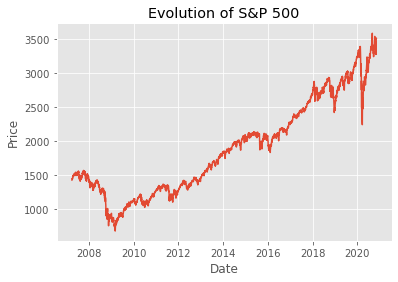

In [542]:
série.visualization()

On peut maintenant afficher le rendement logarithmique journalier de notre série.

## I - Calcul des rendements

,SP500
Date,
2007-04-03,0.009237
2007-04-04,0.001112
2007-04-05,0.003045
2007-04-10,0.003202
2007-04-11,-0.006595
...,...
2020-11-02,0.012243
2020-11-03,0.017643
2020-11-04,0.021808


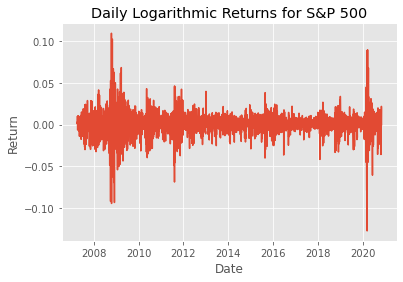

In [543]:
série.returns()

<u>Remarque:</u> On voit bien les fortes varations en 2009 (crise financière) et idem en début 2020 (crise du COVID-19)

## II - Séparation des données en Training/Testing

On sépare ensuite notre data set en deux.

- La première partie (80%) correspond au Training Set
- La seconde partie (20%) correspond au Testing Set

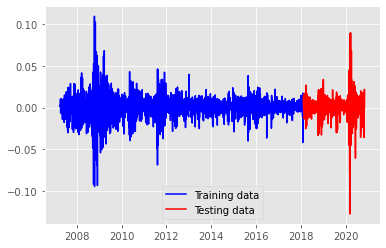

In [544]:
training_data = série.training()
testing_data = série.testing()
plt.plot(training_data,c='b',label='Training data')
plt.plot(testing_data,c='r',label='Testing data')
plt.legend()

## III - Modélisation paramétrique <a class="anchor" id="chapter3"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu dans un premier temps réaliser des méthodes simples de modélisations et de prédictions. L'objectif était tout d'abord de manipuler nos set de données, mais aussi d'apprécier la performance de ces méthodes simples afin de travailler sur des méthodes plus compliquées.

### III.1 - Modèle ARMA(p,q) <a class="anchor" id="chapter3.section1.1"></a>

On rappelle la forme de ce modèle ci-dessous : 

$$ X_{t}= c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t} + \sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}$$

où 
- $c$ : constante
- $\varepsilon _{t}$ : bruit blanc
- $\varphi _{i} $ , $ \theta _{i} $ : parametres du modèle 

Nous allons utiliser une fonction qui permet de retourner le meilleur processus ARIMA par minimisation du critére d'information AIC. Cette recherche de modèle n'est pas optimale mais elle nous permet de sélectionner très rapidement notre modèle pour la suite de nos travaux.

In [545]:
best_pq,model_arima = série.arima(1,1)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  SP500   No. Observations:                 2669
Model:                     ARMA(1, 1)   Log Likelihood                7835.746
Method:                       css-mle   S.D. of innovations              0.013
Date:                Mon, 14 Dec 2020   AIC                         -15663.492
Time:                        18:00:49   BIC                         -15639.934
Sample:                             0   HQIC                        -15654.968
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.000      1.106      0.269      -0.000       0.001
ar.L1.SP500     0.3145      0.150      2.091      0.036       0.020       0.609
ma.L1.SP500    -0.4324      0.143     -3.021      0.003      -0.713      -0.152
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1793           +0.0000j            3.1793            0.0000
MA.1            2.3129           +0.0000j            2.3129            0.0000
-----------------------------------------------------------------------------
"""

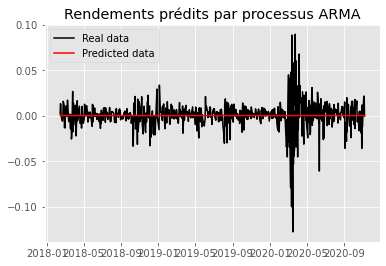

In [546]:
série.arima_modelisation(1,1)


### III.2 - Modèle GARCH(p,q)  <a class="anchor" id="chapter3.section1.2"></a>

[Retour Sommaire](#sommaire)

Comme précédement, nous allons utiliser une fonction de performance et nous allons déterminer les paramètres p et q optimaux pour notre modèle GARCH(p,q).

On rappelle le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela signifie que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [547]:
best_pq , model_garch = série.garch(5,5)
model_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  SP500   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3676.36
Distribution:                  Normal   AIC:                           7364.72
Method:            Maximum Likelihood   BIC:                           7400.06
                                        No. Observations:                 2669
Date:                Mon, Dec 14 2020   Df Residuals:                     2663
Time:                        18:00:57   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0690  1.533e-02      4.503  6.689e-06 [3.900e-02,9.910e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0385  1.270e-02      3.032  2.433e-03 [1.361e-02,6.338e-02]
alpha[1]       0.0886  3.670e-02      2.414  1.577e-02   [1.667e-02,  0.161]
alpha[2]       0.1181  4.926e-02      2.397  1.654e-02   [2.152e-02,  0.215]
beta[1]        0.4395      0.372      1.181      0.238     [ -0.290,  1.169]
beta[2]        0.3307      0.323      1.023      0.306     [ -0.303,  0.964]
============================================================================

Covariance estimator: robust
"""

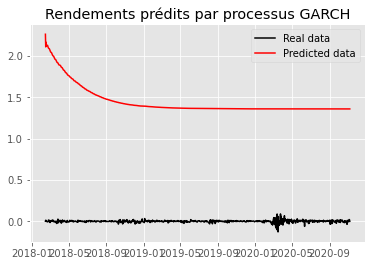

In [548]:
série.garch_modelisation(5,5)

Les résultats ne semblent pas concluant avec ce modèle, il ne peut pas être utilisé pour la suite.

Dans un prochain chapitre, nous reviendrons sur ces prédictions et nous réaliserons une comparaison plus poussée, notamment par rapport aux valeurs réelles, grâce à différentes mesures. Nous comparerons aussi leur performance par rapport au modèle que nous allons décrire dans le prochain chapitre, le boostrapping.

## IV- Bootstrapping & 1ère analyse <a class="anchor" id="chapter4"></a>

[Retour Sommaire](#sommaire)

#### IV.1 - Bootstrapping <a class="anchor" id="chapter4.section1"></a>

On réalise un bootstrapping sur les rendements de notre série de données. Nous générons pour cela 1000 scénarios issus du réechantillonage de notre Training set.

On calcule sur l'ensemble de nos scénarios générés par bootstrapping : 

- <strong>le quantile à 5% et 95% </strong>
- <strong>le quantile à 95% </strong>
- <strong>la moyenne </strong>

Puis on affiche le graphique comprenant ces trois mesures.

Date
2018-02-13    0.000372
2018-02-14    0.000460
2018-02-15    0.000036
2018-02-16    0.000169
2018-02-20    0.000124
                ...   
2020-11-02   -0.000387
2020-11-03    0.000323
2020-11-04   -0.000111
2020-11-05    0.000657
2020-11-06    0.000562
Length: 668, dtype: float64

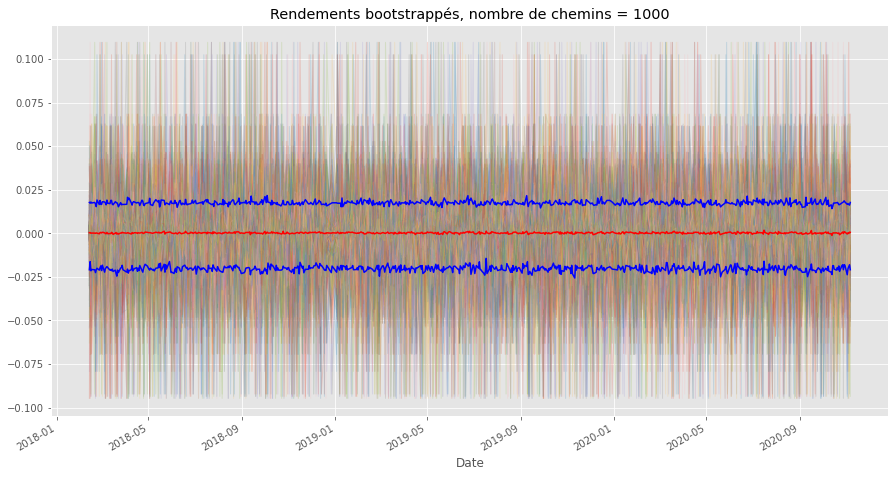

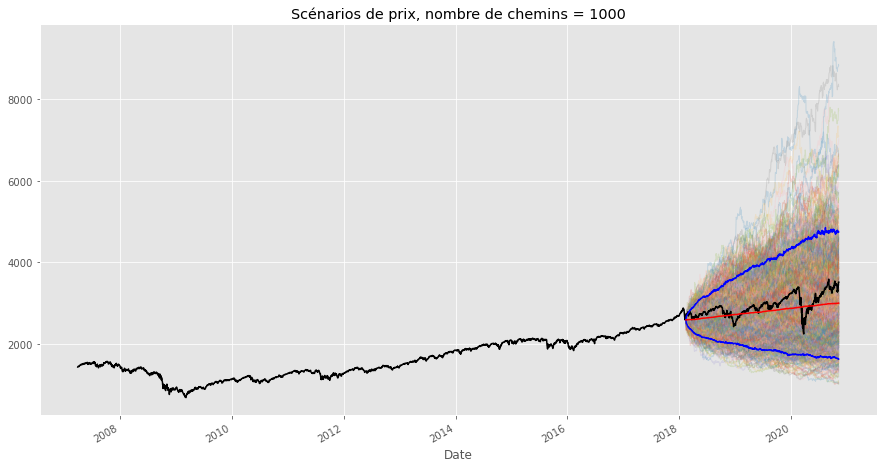

In [549]:
série.historical_simulation(1000)

## V - Filtred Historical Simulation <a class="anchor" id="chapter7"></a>

[Retour Sommaire](#sommaire)

<u><strong> Etape 1 :</strong> Trouver le meilleur modèle de volatilité conditionnel (GARCH) pour le rendement à modéliser </u>

Pour rappel, nous avons défini une fonction <i> best_param_garch </i> en <strong> III.1.1 </strong>. Nous allons nous en servir afin de trouver le meilleur modéle GARCH

<u><strong> Etape 2 : </strong> Standardisation des rendements </u>

<u><strong>Etape 3 :</strong> Bootstrapping à partir des rendements standardisés </u>

Date
2018-02-13    0.000226
2018-02-14    0.000293
2018-02-15    0.000314
2018-02-16    0.000583
2018-02-20    0.000069
                ...   
2020-11-02    0.000511
2020-11-03    0.000134
2020-11-04   -0.000189
2020-11-05    0.000327
2020-11-06    0.000444
Length: 668, dtype: float64

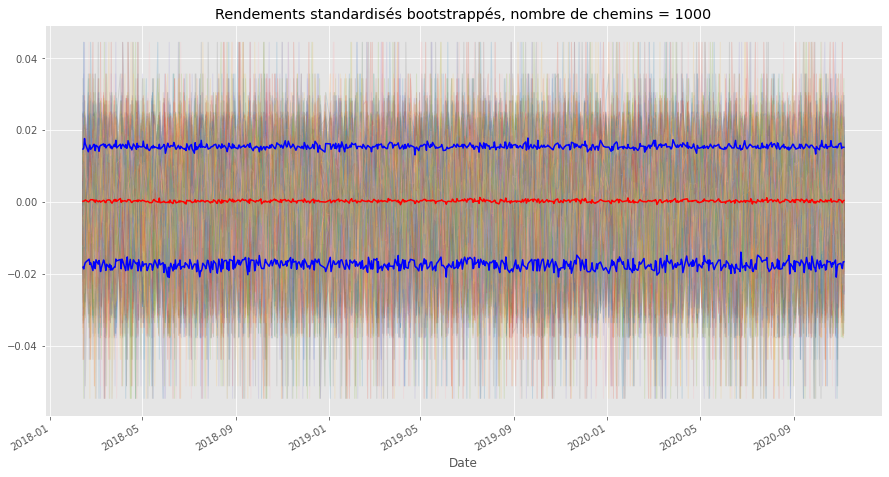

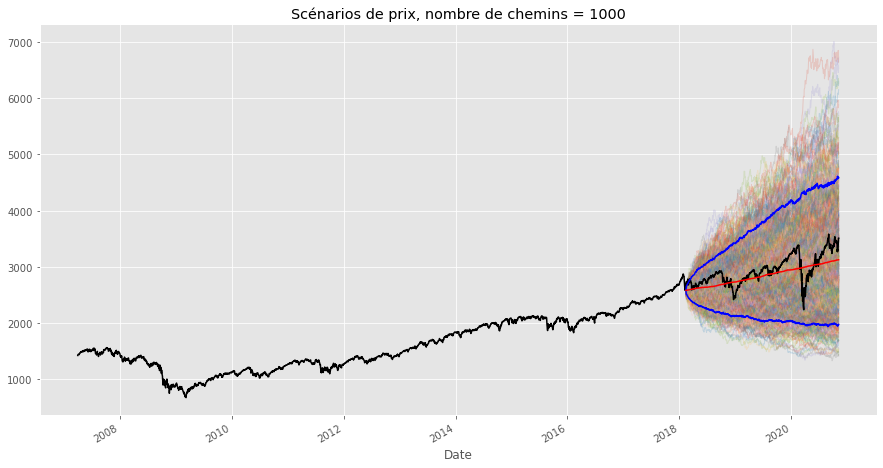

In [550]:
série.filtered_historical_simulation(1000)

## VI - Fonction de performance <a class="anchor" id="chapter6"></a>

[Retour Sommaire](#sommaire)

Nous allons maintenant comparer de façon statistique les performances des scénarios générés. Pour cela, nous avons réalisé une fonction comprenant un certain nombre de mesures permettant de comparer les différents scénarios.

## Fonctions simples

Nous avons commencé par définir 3 fonctions simples qui permettent de calculer : 

- la déviation en valeur absolue à la médiane d'une distribution de fonction 
- l'asymétrie d'une distribution de fonction 
- le kurtosis d'une distribution de fonction 

NB: Chacune de ces fonctions est réalisé de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

In [551]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)

In [552]:
#This function calculates the skewness value of a distribution function.
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

In [553]:
#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)

## Mesures de distances entre distributions

Nous avons ensuite choisi 3 mesures permettant de calculer la distance entre deux distributions de fonctions : 

- la distance d'Hellinger
- la distance de Kullback-Leiber
- la distance de Bhattacharyya

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

<strong><u> Z-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ Z = \frac{\bar{X} - \mu_{0}}{s} $$

où : 
- $Z$ : Z-test
- $\bar{X}$ : moyenne de l'échantillon
- $\mu_{0} $ : espérance
- $s$ : écart-type


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
- https://en.wikipedia.org/wiki/Z-test

In [554]:
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from statsmodels.stats.weightstats import ztest

def Z_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> (Student) t-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ t = \frac{m - \mu_{0}}{s/ \sqrt{n}} $$

où : 
- $t$ : t-test
- $m$ : espérance
- $\mu_{0} $ : valeur théorique
- $s$ : écart-type
- $n$ : taille de l'échantillon


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://en.wikipedia.org/wiki/Student%27s_t-test

In [555]:
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def t_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> F-Test  - Comparaison de la variance des distributions </strong></u> 

$$ F = \frac{Explained Variance}{Unexplained Variance} $$

avec :

$$ Explained Variance = \sum_{i = 1}^{K}n_{i} ({\bar {Y}}_{i \cdot} - {\bar {Y}})^{2} / (K - 1) $$
et
$$ Unexplained Variance = \sum_{i = 1}^{K} \sum_{j = 1}^{n_{i}} ({\bar {Y}}_{ij \cdot} - {\bar {Y}}_{i \cdot})^{2} / (N - K) $$

où 
- $ {Y}_{ij} $ est la j-ème observation dans la i-ème sur K groupes
- N : taille globale de l'échantillon 


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- https://en.wikipedia.org/wiki/F-test

In [556]:
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import f_oneway

def F_test(data):
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Test de rang de Mann-Whitneyu  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

La statistique U de Mann-Whitney correspondante est définie comme suit:

$$ U = \sum_{i = 1}^{n} \sum_{j = 1}^{m} S(X_{i}, Y_{j})  $$

avec

$
  S (X, Y) = \left\{
          \begin{array}{ll}
            1 & \qquad \mathrm{si}\quad Y < X \\
            \frac{1}{2} & \qquad \mathrm{si}\quad Y = X \\
            0 & \qquad \mathrm{si}\quad Y > X \\
          \end{array}
        \right.
$


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [557]:
#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Mann_Whitneyu(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Test de rang de Wilcoxon  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

Le test statistique de Wilcoxon est défini comme suit:

$$ W = \sum_{i = 1}^{N_{r}} [sgn(x_{2,i} - x_{1,i}) * R_{i}]$$

avec
- $W$ : test statistique 
- $N_{r}$ : taille de l'échantillon
- $sng$ : signe de la function
- $x_{2,i} - x_{1,i}$ : paires classées correspondantes des deux distributions
- $R_{i}$ : rang i

Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

In [558]:
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wilcoxon(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Distance de Wasserstein </strong></u> 

La première distance de Wasserstein entre les distributions $u$ et $v$ est:


$$ l_{1}(u,v) =  \inf_{\substack{\pi \in \Gamma(u,v)}} \int_{\mathbb{R}x\mathbb{R}} |x - y|d\pi(x,y)$$

Lien : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [559]:
#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)

Grâce à toutes les fonctions présentées dans la partie précédente, nous avons réalisé une fonction globale qui, pour un unique dataset en entrée (au format DataFrame), retourne un tableau comparatif comportant les éléments suivants : 

- Espérance & Variance 
- Min / Q25% / Médiane / Q75% / Max
- Déviation de la médiane en valeure absolue
- Asymétrie & Kurtosis
- <strong> Z-test </strong> & <strong>t-test</strong> (pour la comparaison de la moyenne)
- <strong>F-test </strong>(pour la comparaison de la variance)
- <strong>Test de rang de Mann-Whitneyu </strong> & <strong> Test de Wilcoxon</strong> (pour comparer le ranking de deux distributions)
- <strong> Mesure de Wasserstein </strong> (pour comparer la distance entre deux distributions)


<u> NB:</u> Cette fonction est réalisée de telle sorte qu'elle peut être appliqué à un dataset comportant un ou plusieurs jeux de distributions. Dans le cas d'un dataset multiple, les distance citées précédement seront toujours calculées en fonction de la première colonne de ce dataset.

<strong><u> Conséquence: </strong></u>  Il faut impérativement placer les valeurs réelles dans la première colonne de notre DataFrame, afin de pouvoir comparer chaque simulation avec les valeurs réelles, et ainsi comparer la performance de chacunes de nos simulations.

Nous testons notre fonction de performance sur le dataframe de prédictions, qui comporte : 

- Nos données réelles
- La moyenne de nos scénarii générés par Historical Simulation
- La moyenne de nos scénarii générés par Filtered Historical Simulation

In [560]:
série.describe()

,Testing Set,Simulated Data HS,Simulated Data FHS
count,668,668.000000,668.000000
mean,0.000417119,0.000256,0.000297
std,0.0151892,0.000407,0.000308
min,-0.127652,-0.000962,-0.000679
25%,-0.00433513,-0.000021,0.000087
50%,0.00105752,0.000242,0.000285
75%,0.00688513,0.000533,0.000520
max,0.0896832,0.001466,0.001498
Median Absolute Deviation,0.0090864,0.000323,0.000246
skew,-1.03173,0.067575,0.115501


## Conclusions